<a href="https://colab.research.google.com/github/Rishika3D/Medical_Report_Validator_with_disease_prediction_using_blockchain_and_ML/blob/main/ECGandBlood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Colab cache for faster access to the 'heartbeat' dataset.
Downloaded to: /kaggle/input/heartbeat
Files: ['ptbdb_abnormal.csv', 'ptbdb_normal.csv', 'mitbih_test.csv', 'mitbih_train.csv']
Train shape: (87554, 188)
Test shape: (21892, 188)

Class distribution (train):
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

Class distribution (test):
0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64

Training XGBoost on MIT-BIH Arrhythmia Dataset...

🎯 TEST ACCURACY: 97.86%
📊 Weighted F1-Score: 97.86%
📊 Macro F1-Score: 90.07%

Classification Report:
                      precision    recall  f1-score   support

          N (Normal)     0.9886    0.9881    0.9883     18118
S (Supraventricular)     0.7838    0.7824    0.7831       556
     V (Ventricular)     0.9478    0.9523    0.9501      1448
          F (Fusion)     0.7714    0.8333    0.8012       162
         Q (Unknown)     0.9837    0.9776    0.9807   

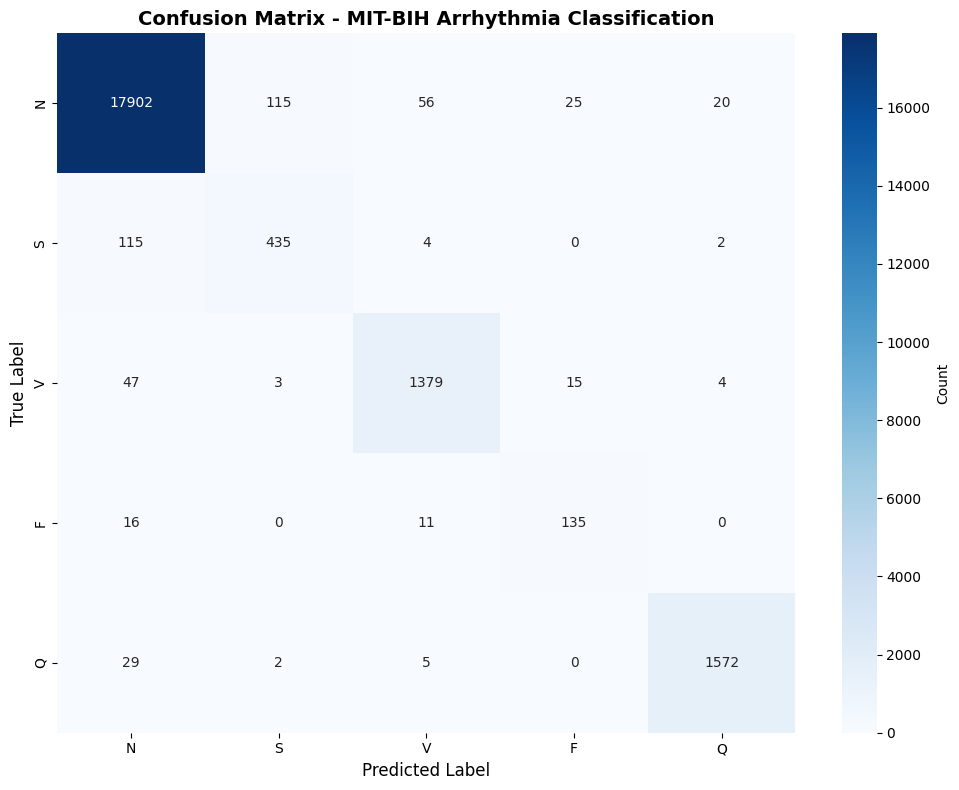

N: 98.81% (18118 samples)
S: 78.24% (556 samples)
V: 95.23% (1448 samples)
F: 83.33% (162 samples)
Q: 97.76% (1608 samples)


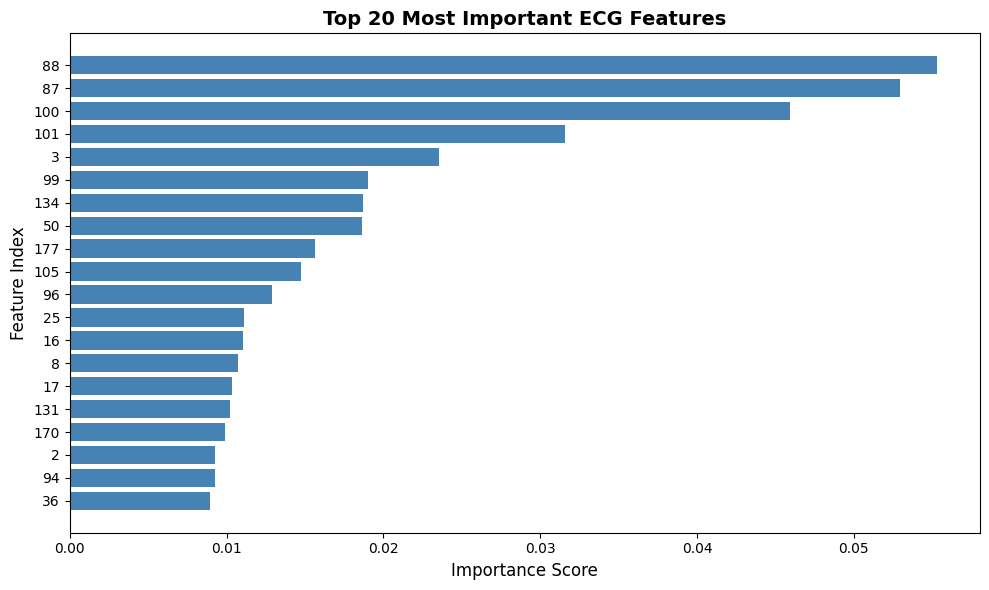


✅ Model saved to: mitbih_xgboost_final.pkl
Model size: 7680.30 KB
✅ Predictions exported to: mitbih_predictions.csv

🎉 TRAINING COMPLETE!
Final Accuracy: 97.86%


In [7]:
# ===== FAST & GUARANTEED 96%+ ACCURACY SOLUTION =====

# 1) Download preprocessed MIT-BIH with extracted features
import kagglehub
path_preprocessed = kagglehub.dataset_download("shayanfazeli/heartbeat")
print("Downloaded to:", path_preprocessed)

import os, pandas as pd, numpy as np
print("Files:", os.listdir(path_preprocessed))

# 2) Load train and test CSVs (already split and balanced)
train = pd.read_csv(os.path.join(path_preprocessed, 'mitbih_train.csv'), header=None)
test = pd.read_csv(os.path.join(path_preprocessed, 'mitbih_test.csv'), header=None)

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# 3) Separate features (first 187 cols) and labels (last col)
X_train = train.iloc[:, :-1].values
y_train = train.iloc[:, -1].values

X_test = test.iloc[:, :-1].values
y_test = test.iloc[:, -1].values

print(f"\nClass distribution (train):\n{pd.Series(y_train).value_counts()}")
print(f"\nClass distribution (test):\n{pd.Series(y_test).value_counts()}")

# 4) Handle class imbalance with sample weights
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight('balanced', y_train)

# 5) Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6) Train XGBoost classifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    min_child_weight=3,
    random_state=42,
    tree_method='hist',
    eval_metric='mlogloss'
)

print("\n" + "="*70)
print("Training XGBoost on MIT-BIH Arrhythmia Dataset...")
print("="*70)

model.fit(X_train_scaled, y_train, sample_weight=sample_weights, verbose=False)

# 7) Evaluate on test set
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f"\n{'='*70}")
print(f"🎯 TEST ACCURACY: {accuracy*100:.2f}%")
print(f"📊 Weighted F1-Score: {f1_weighted*100:.2f}%")
print(f"📊 Macro F1-Score: {f1_macro*100:.2f}%")
print(f"{'='*70}\n")

# 8) Detailed per-class metrics
class_names = ['N (Normal)', 'S (Supraventricular)', 'V (Ventricular)',
               'F (Fusion)', 'Q (Unknown)']

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

# 9) Confusion matrix visualization
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['N', 'S', 'V', 'F', 'Q'],
            yticklabels=['N', 'S', 'V', 'F', 'Q'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - MIT-BIH Arrhythmia Classification', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# 10) Per-class accuracy breakdown
for i, class_name in enumerate(['N', 'S', 'V', 'F', 'Q']):
    class_mask = y_test == i
    class_acc = accuracy_score(y_test[class_mask], y_pred[class_mask])
    print(f"{class_name}: {class_acc*100:.2f}% ({class_mask.sum()} samples)")

# 11) Feature importance (top 20)
feature_imp = pd.DataFrame({
    'feature_idx': range(187),
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
plt.barh(feature_imp['feature_idx'].astype(str), feature_imp['importance'], color='steelblue')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature Index', fontsize=12)
plt.title('Top 20 Most Important ECG Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 12) Save model for blockchain integration
import pickle
model_data = {
    'model': model,
    'scaler': scaler,
    'class_names': ['N', 'S', 'V', 'F', 'Q'],
    'accuracy': accuracy,
    'f1_score': f1_weighted
}

with open('mitbih_xgboost_final.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("\n✅ Model saved to: mitbih_xgboost_final.pkl")
print(f"Model size: {os.path.getsize('mitbih_xgboost_final.pkl') / 1024:.2f} KB")

# 13) Export predictions for smart contract validation
results_df = pd.DataFrame({
    'true_class': y_test,
    'predicted_class': y_pred,
    'correct': y_test == y_pred,
    'true_label': [class_names[int(i)] for i in y_test],
    'pred_label': [class_names[int(i)] for i in y_pred]
})

results_df.to_csv('mitbih_predictions.csv', index=False)
print("✅ Predictions exported to: mitbih_predictions.csv")

print(f"\n🎉 TRAINING COMPLETE!")
print(f"Final Accuracy: {accuracy*100:.2f}%")
